In [1]:
# Import all the needed libraries
import pyterrier as pt
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import algos
import os
if not pt.started():
    pt.init()

PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [2]:
# Load the dataset
dataset = pt.datasets.get_dataset("trec-deep-learning-passages")

In [3]:
index_ref = pt.IndexRef.of(os.getcwd() + "./passage_index/data.properties")

In [4]:
index = pt.IndexFactory.of(index_ref)

17:19:03.964 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.


In [7]:
# Divergence
qe = (pt.BatchRetrieve(index_ref, wmodel="BM25") >> 
    pt.rewrite.QueryExpansion(index_ref) >> 
    pt.BatchRetrieve(index_ref, wmodel="BM25")
)

17:32:21.803 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
17:32:23.411 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
17:32:24.862 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.


In [8]:
#def given qrels dataset, return if qid, docid exists in ranked model
import pandas as pd
import gc
from tqdm import tqdm

def check_qrel_queries():
    temp1 = dataset.get_topicsqrels("test-2019")[0]
    queries_df = temp1.sort_values(by=['qid'])

    #label, docno, qid
    temp2 = dataset.get_topicsqrels("test-2019")[1]
    qrels_df = temp2.sort_values(by=['qid'])
    
    docs_qrels = pd.DataFrame(columns =['rank','docid','score','qid','label'])

    for index, row in tqdm(qrels_df.iterrows()):
        qid = row['qid']

        #we don't care about non-relevant documents
#         if row['label'] == 0:
#               continue

        docNo = row["docno"]        
        query = queries_df[queries_df["qid"] == qid].iloc[0]["query"]
        
        # Returns the top 1000 relevant documents for this query (that has as qrel)
        result = qe.search(query)
        
        docs_qrels = docs_qrels.append(check_rel_doc_present(docNo, qid, query, result,row['label']), ignore_index=True)
        
        del result
        gc.collect()
        
    
    return docs_qrels

#given a docid, search if the doc id exists in result.
def check_rel_doc_present(docid, qid, query, result,label):

    # Hypothesis that this if statement is always true
    if docid in list(result["docno"]):
        R = result[result["docno"]==docid]
        rank = R.iloc[0]["rank"]
        score = R.iloc[0]["score"]
        doc_id = R.iloc[0]["docid"]
        # print("rank : ", rank)
        # print("score: ", score)
        # print("docid : ", doc_id)
        return {"rank":rank, "docid":doc_id, "score":round(score,2), "qid":qid, "query":query, "label":label}
    else:
        # Then we have document that were not found in the top-1000 ranked documents despite 
        # the query they belong to had a qrel provided
        
        # print("not found")
        return {"rank":-1, "docid":docid, "score":-1, "qid":qid, "query":query, "label":label}

In [9]:
temp = check_qrel_queries()

17:32:24.901 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8
17:32:24.945 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


0it [00:00, ?it/s]

17:32:25.860 [main] WARN org.terrier.querying.QueryExpansion - qemodel control not set for QueryExpansion post process. Using default model Bo1


9260it [1:02:44,  2.46it/s]


In [11]:
temp.to_csv("QUERIES_W_QRESL_RETRIEVED_AND_NOT_RETRIEVED_QUERY_REWRITTEN.csv", index=False)

In [173]:
temp

,rank,docid,score,qid,label,query,passages
0,15,8820474,22.13,1037798,0,who is robert gray,Medley: Just Like Me / Summer Song/ Tall Dark ...
1,27,3387556,20.10,1037798,1,who is robert gray,United States History. The lower section of th...
2,302,336322,15.99,1037798,0,who is robert gray,Top definition. groutfit. (noun) : an outfit m...
3,975,3310854,14.60,1037798,0,who is robert gray,William Thomas Gray. Billy Gray was born on Ja...
4,-1,3295801,-1.00,1037798,0,who is robert gray,"In 1805, the first official party of Americans..."
...,...,...,...,...,...,...,...
9255,-1,3705169,-1.00,962179,0,when was the salvation army founded,1 The Protestant Episcopal Church is an offsho...
9256,751,372500,15.13,962179,0,when was the salvation army founded,"On September 18, 1947. That is when the United..."
9257,-1,3800173,-1.00,962179,0,when was the salvation army founded,History of the Tower of London. In London on C...
9258,-1,3026310,-1.00,962179,0,when was the salvation army founded,"However, interest in his life and work has inc..."


In [12]:
DOCS = pd.read_csv("./collection.tsv", sep='\t', header=None, names=["passage_id", "passage"])

In [143]:
len(DOCS)

8841823

In [13]:
queries_without_doc_retrieved = temp

In [14]:
passages = [(DOCS.iloc[(int(x))]['passage']) for x in queries_without_doc_retrieved['docid']]

In [15]:
queries_without_doc_retrieved['passages'] = passages

In [16]:
queries_without_doc_retrieved

,rank,docid,score,qid,label,query,passages
0,15,8820474,22.13,1037798,0,who is robert gray,Medley: Just Like Me / Summer Song/ Tall Dark ...
1,27,3387556,20.10,1037798,1,who is robert gray,United States History. The lower section of th...
2,302,336322,15.99,1037798,0,who is robert gray,Top definition. groutfit. (noun) : an outfit m...
3,975,3310854,14.60,1037798,0,who is robert gray,William Thomas Gray. Billy Gray was born on Ja...
4,-1,3295801,-1.00,1037798,0,who is robert gray,"In 1805, the first official party of Americans..."
...,...,...,...,...,...,...,...
9255,-1,3705169,-1.00,962179,0,when was the salvation army founded,1 The Protestant Episcopal Church is an offsho...
9256,751,372500,15.13,962179,0,when was the salvation army founded,"On September 18, 1947. That is when the United..."
9257,-1,3800173,-1.00,962179,0,when was the salvation army founded,History of the Tower of London. In London on C...
9258,-1,3026310,-1.00,962179,0,when was the salvation army founded,"However, interest in his life and work has inc..."


In [17]:
queries_without_doc_retrieved.to_csv("QUERIES_WITHOUT_DOC_IN_RETRIEVAL_WITHQREL_Pas.csv", index=False)

In [30]:
robert_gray = queries_without_doc_retrieved[queries_without_doc_retrieved['query']=="who is robert gray"]

In [178]:
ert = robert_gray[robert_gray['score']!=-1.0]
ert.sort_values(by='score')

,rank,docid,score,qid,label,query,passages
3,975,3310854,14.60,1037798,0,who is robert gray,William Thomas Gray. Billy Gray was born on Ja...
46,956,184064,14.63,1037798,0,who is robert gray,Roberts Fire More Info. Roberts Fire Informati...
59,928,2970892,14.66,1037798,0,who is robert gray,Kenneth Gray (I) Actor. Kenneth Gray is an act...
14,923,3150376,14.67,1037798,0,who is robert gray,"Robert Green was born in Bolton, Lancashire. O..."
136,918,7081475,14.68,1037798,0,who is robert gray,Robert - Name Meaning with a Detailed Descript...
...,...,...,...,...,...,...,...
19,4,3620983,26.17,1037798,0,who is robert gray,"I'm not a politician, said Gray in a Wednesday..."
32,3,3641634,27.33,1037798,3,who is robert gray,"Captain Robert Gray, May 1972. Discovering the..."
103,2,8760873,30.00,1037798,0,who is robert gray,Team Mississippi Robert Gray For Governor Offi...
109,1,8760864,30.69,1037798,0,who is robert gray,Team Mississippi Robert Gray For Governor Offi...


In [32]:
print('Not retrieved documents: ',len(robert_gray[robert_gray['rank']==-1]), ' Retrieved documents: ', len(robert_gray[robert_gray['rank']!=-1]))

Not retrieved documents:  83  Retrieved documents:  71


In [53]:
rewritten_queries = qe.search("who is robert gray")

In [63]:
rewritten_queries = rewritten_queries.drop(columns=['qid', 'docno', 'rank', 'score', 'query_0'])

In [64]:
robert_gray_qe = pd.merge(rewritten_queries, robert_gray, on='docid')

In [65]:
robert_gray_qe

,docid,query_x,rank,score,qid,label,query_y,passages
0,8760867,applypipeline:off who^1.075470753 robert^1.409...,0,31.09,1037798,0,who is robert gray,Robert Gray. A surprise came on the Democratic...
1,8760864,applypipeline:off who^1.075470753 robert^1.409...,1,30.69,1037798,0,who is robert gray,Team Mississippi Robert Gray For Governor Offi...
2,8760873,applypipeline:off who^1.075470753 robert^1.409...,2,30.00,1037798,0,who is robert gray,Team Mississippi Robert Gray For Governor Offi...
3,3641634,applypipeline:off who^1.075470753 robert^1.409...,3,27.33,1037798,3,who is robert gray,"Captain Robert Gray, May 1972. Discovering the..."
4,3620983,applypipeline:off who^1.075470753 robert^1.409...,4,26.17,1037798,0,who is robert gray,"I'm not a politician, said Gray in a Wednesday..."
...,...,...,...,...,...,...,...,...
66,7081475,applypipeline:off who^1.075470753 robert^1.409...,918,14.68,1037798,0,who is robert gray,Robert - Name Meaning with a Detailed Descript...
67,3150376,applypipeline:off who^1.075470753 robert^1.409...,923,14.67,1037798,0,who is robert gray,"Robert Green was born in Bolton, Lancashire. O..."
68,2970892,applypipeline:off who^1.075470753 robert^1.409...,928,14.66,1037798,0,who is robert gray,Kenneth Gray (I) Actor. Kenneth Gray is an act...
69,184064,applypipeline:off who^1.075470753 robert^1.409...,956,14.63,1037798,0,who is robert gray,Roberts Fire More Info. Roberts Fire Informati...


In [68]:
robert_gray_qe.to_csv("robert_gray_query_rewriting.csv", index=False)

In [146]:
robert_grar_no_rewriting = pd.read_csv("robert_gray_no_query_rewriting.csv")

In [147]:
rewritten_queries = qe.search("who is robert gray")

In [176]:
er = rewritten_queries.sort_values(by='score', ascending=False)
er

,qid,docid,docno,rank,score,query_0,query
0,1,8760867,8760867,0,31.086427,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
1,1,8760864,8760864,1,30.692105,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
2,1,8760873,8760873,2,30.002312,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
3,1,3641634,3641634,3,27.326486,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
4,1,3620983,3620983,4,26.168951,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
...,...,...,...,...,...,...,...
992,1,3150375,3150375,992,14.603231,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
991,1,2659261,2659261,991,14.603231,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
990,1,1451291,1451291,990,14.603231,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
998,1,4117030,4117030,998,14.588661,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...


In [158]:
robert_gray_qe = pd.merge(queries_without_doc_retrieved, robert_grar_no_rewriting, on='docid')

In [164]:
robert_gray_qe = pd.merge(robert_gray_qe, rewritten_queries, on='docid')
worse_off = robert_gray_qe[robert_gray_qe['docid']==3227356]
worse_off.to_csv("robert_gray_query_rewriting_worse_off.csv", index=False)

In [165]:
worse_off

,rank_x,docid,score_x,qid_x,label_x,query_x,passages_x,rank_y,score_y,qid_y,...,rank_y,score_y,query_0_y,query_y,qid,docno,rank,score,query_0,query
4,79,3227356,17.79,1037798,0,who is robert gray,Because Billy the Kid was 21 at the time of hi...,73,19.0,1037798,...,79,17.791418,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...,1,3227356,79,17.791418,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...


In [157]:
robert_gray_qe[abs(robert_gray_qe["score_x"]-robert_gray_qe["score_y"]) > 0.001]

,docid,rank_x,score_x,query_x,rank_y,score_y,qid_y,label,query_y,passages
0,8760867,0,31.086427,applypipeline:off who^1.075470753 robert^1.409...,0,31.09,1037798,0,who is robert gray,Robert Gray. A surprise came on the Democratic...
1,8760864,1,30.692105,applypipeline:off who^1.075470753 robert^1.409...,1,30.69,1037798,0,who is robert gray,Team Mississippi Robert Gray For Governor Offi...
2,8760873,2,30.002312,applypipeline:off who^1.075470753 robert^1.409...,2,30.00,1037798,0,who is robert gray,Team Mississippi Robert Gray For Governor Offi...
3,3641634,3,27.326486,applypipeline:off who^1.075470753 robert^1.409...,3,27.33,1037798,3,who is robert gray,"Captain Robert Gray, May 1972. Discovering the..."
4,3620983,4,26.168951,applypipeline:off who^1.075470753 robert^1.409...,4,26.17,1037798,0,who is robert gray,"I'm not a politician, said Gray in a Wednesday..."
5,2157456,5,25.313954,applypipeline:off who^1.075470753 robert^1.409...,5,25.31,1037798,0,who is robert gray,"Closest Airport to Killeen, TX. The closest ai..."
6,4788864,6,25.074882,applypipeline:off who^1.075470753 robert^1.409...,6,25.07,1037798,0,who is robert gray,The newlyweds reunited and shortly gave birth ...
7,8760868,7,24.773020,applypipeline:off who^1.075470753 robert^1.409...,7,24.77,1037798,0,who is robert gray,Mississippi Truck Driver Who Didnât Vote Bec...
8,4291373,8,24.586046,applypipeline:off who^1.075470753 robert^1.409...,8,24.59,1037798,0,who is robert gray,Former 6ABC weather reporter Dave Roberts will...
10,3030655,10,23.486556,applypipeline:off who^1.075470753 robert^1.409...,10,23.49,1037798,0,who is robert gray,"Pampa, Texas. Pampa is a city in Gray County, ..."


In [69]:
robert_gray_qe['passages']

0     Robert Gray. A surprise came on the Democratic...
1     Team Mississippi Robert Gray For Governor Offi...
2     Team Mississippi Robert Gray For Governor Offi...
3     Captain Robert Gray, May 1972. Discovering the...
4     I'm not a politician, said Gray in a Wednesday...
                            ...                        
66    Robert - Name Meaning with a Detailed Descript...
67    Robert Green was born in Bolton, Lancashire. O...
68    Kenneth Gray (I) Actor. Kenneth Gray is an act...
69    Roberts Fire More Info. Roberts Fire Informati...
70    William Thomas Gray. Billy Gray was born on Ja...
Name: passages, Length: 71, dtype: object

In [70]:
all_passages = ""

for p in robert_gray_qe['passages']:
    all_passages += p

In [71]:
all_words = all_passages.split()

In [72]:
from collections import Counter

# Pass the split_it list to instance of Counter class.
Counter = Counter(all_words)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common()

In [76]:
!pip install nltk

In [131]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

all_stopwords = stopwords.words('english')
sw_list = ['It','Â·','...', 'A', 'In', '.',',','(',')',':','The','$','1', '2', '3', '?', 'I', '4', '5', '6', '7', '8', '9', ';', "'s", '-', 'x', 'L.',"'", "'"]
all_stopwords.extend(sw_list)

text_tokens = word_tokenize(all_passages)

tokens_without_sw = [word.lower() for word in text_tokens if not word in all_stopwords]

print(tokens_without_sw)

['robert', 'gray', 'surprise', 'came', 'democratic', 'side', 'race', 'mississippi', 'governor', 'robert', 'gray', 'retired', 'firefighter', 'truck', 'driver', 'democratic', 'nominee', 'admitted', 'associated', 'press', "n't", 'even', 'vote', 'tuesday', 'election.team', 'mississippi', 'robert', 'gray', 'for', 'governor', 'offical', 'page', 'robert', 'gray', 'never', 'would', 'made', 'without', 'god', 'if', 'god', 'god', 'impossible', 'god', 'uses', 'least', 'among', 'us', 'robert', 'head', 'tail', 'top', 'never', 'bottom', 'he', 'bless', 'coming', 'bless', 'coming', 'all', 'praises', 'thanks', 'god.team', 'mississippi', 'robert', 'gray', 'for', 'governor', 'offical', 'page', 'shared', 'link', 'team', 'mississippi', 'robert', 'gray', 'for', 'governor', 'offical', 'page', 'shared', 'post', 'today', 'nov.', '2nd', 'on', 'day', 'election', 'invite', 'join', 'us', 'holding', 'prayer', 'robert', 'gray', 'governor', 'mississippi', 'democratic', 'candidates.captain', 'robert', 'gray', 'may', '1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jbies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
from collections import Counter

# Pass the split_it list to instance of Counter class.
Counter_st = Counter(tokens_without_sw)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur_st = Counter_st.most_common()

In [133]:
most_occur_st

[('gray', 147),
 ('robert', 56),
 ('columbia', 28),
 ('name', 23),
 ('states', 17),
 ('roberts', 15),
 ('united', 15),
 ('river', 14),
 ('captain', 13),
 ('first', 13),
 ('american', 12),
 ('county', 12),
 ('michael', 12),
 ('born', 11),
 ('british', 11),
 ('mississippi', 10),
 ('1792', 10),
 ('explored', 10),
 ('named', 10),
 ('also', 10),
 ('governor', 9),
 ('he', 9),
 ('democratic', 8),
 ('pampa', 8),
 ('john', 8),
 ('one', 8),
 ('may', 7),
 ('miles', 7),
 ('texas', 7),
 ('area', 7),
 ('northwest', 7),
 ('actor', 7),
 ('city', 6),
 ('meaning', 6),
 ('color', 6),
 ('garibaldi', 6),
 ('known', 6),
 ('english', 6),
 ('hair', 6),
 ('matter', 6),
 ('green', 6),
 ('truck', 5),
 ('driver', 5),
 ('would', 5),
 ('top', 5),
 ('ship', 5),
 ('mouth', 5),
 ('state', 5),
 ('see', 5),
 ('airport', 5),
 ('army', 5),
 ('billy', 5),
 ('west', 5),
 ('use', 5),
 ('capt', 5),
 ('coast', 5),
 ('admitted', 4),
 ("n't", 4),
 ('vote', 4),
 ('for', 4),
 ('page', 4),
 ('god', 4),
 ('man', 4),
 ('killeen', 4),

No handles with labels found to put in legend.


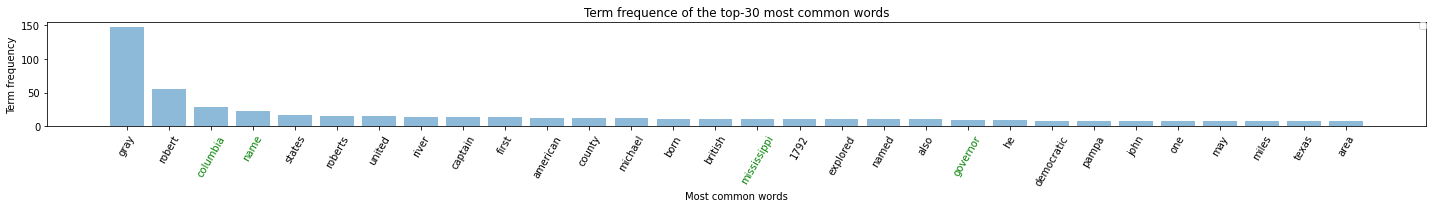

In [175]:
# make a plot of the top-k words in a bar chart for the time they occur
# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.

objects = [x[0] for x in most_occur_st[:30]]
y_pos = np.arange(len(objects))
performance = [x[1] for x in most_occur_st[:30]]
plt.figure(figsize=(20, 3))  # width:20, height:3
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Term frequency')
plt.xlabel('Most common words')
plt.title('Term frequence of the top-30 most common words')
plt.xticks(rotation=60)

import statistics
# plt.axhline(y=statistics.mean(performance), color='g', linestyle='--', label="Mean TF")

ax = plt.gca()


ax.get_xticklabels()[2].set_color('green')

ax.get_xticklabels()[3].set_color('green')


ax.get_xticklabels()[15].set_color('green')

ax.get_xticklabels()[20].set_color('green')

# Add legend
plt.legend(loc=1, fontsize='small', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
plt.savefig('top_30_common_words_and_mean_bar_qe.svg')
plt.show()

In [141]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

frequencies = []

for word in ['mississippi', 'governor', 'will', 'columbia', 'name', 'year', 'made']:
    w = ps.stem(word)
    try :
        frequencies.append((w,index.getLexicon()[w].getDocumentFrequency()))
    except :
        print('Word : {}, not found'.format(w))

In [142]:
frequencies

[('mississippi', 12664),
 ('governor', 13835),
 ('will', 951484),
 ('columbia', 15951),
 ('name', 394773),
 ('year', 773694),
 ('made', 266271)]